In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# your function must import layout and constants
# this is structured to work both in Jupyter notebook and from the command line
try:
    from . import layout
    from . import constants
except ImportError:
    import layout
    import constants

import logging
import re
import json
import secrets
from time import time
from pathlib import Path
from datetime import datetime
from os import path

import requests
from dictor import dictor

AttributeError: 'int' object has no attribute 'count'

In [3]:
def _time_now():
    return datetime.now().strftime("%H:%M")

In [27]:
def _fetch_quotes():
    '''fetch quotes from reddit'''
    error = False
    logging.debug('fetching data from reddit')
    raw_quotes = [constants.error_text]
    try:
        r = requests.get(constants.quotes_url, headers=constants.headers)
    except requests.RequestException as e:
        logging.error(f'failed to fetch quotes from {constants.quotes_url}, {e}')
    if r.status_code == 200:
        try:
            json_data = dictor(r.json(), constants.quote_data_addr)
            raw_quotes = [dictor(q, constants.quote_title_addr) for q in json_data]
        except json.JSONDecodeError as e:
            logging.error(f'bad json data: {e}')
            raw_quotes = [constants.error_text]
            error = True
    else:
        logging.warning(f'error accessing {constants.quotes_url}: code {r.status_code}')
        raw_quotes = [constants.error_text]
        error = True
        
    if len(raw_quotes) < 1:
        raw_quotes = [constants.error_text]
        error = True
        
    return (raw_quotes, error)


In [5]:
def _process_quotes(raw_quotes):
    processed_quotes = []
    logging.debug(f'processing {len(raw_quotes)} quotes')
    for quote in raw_quotes:
        # make sure we have a string to work with
        quote = str(quote)
        # sub double quotes for any other quote character or '' 
        q = re.sub('“|”|\'\'|"', '', quote)
        # sub single quote for ’ character
        q = re.sub('’', "'", q)
        # sub minus for endash, emdash, hyphen, ~
        q = re.sub('-|–|—|~|--|―', '-', q)
        # clean trailing whitespace in quotes
        q = re.sub('\s+"', '"', q)
        # split quote from attirbution
        match = re.match('(.*)\s{0,}-\s{0,}(.*)', q)

        if hasattr(match, 'groups'):
            if len(match.groups()) > 1:
                text = match.group(1).strip()
                attribution = match.group(2).strip().title()
            else:
                text = match.group(1).strip()
                attribution = None

        # append quotes to dictionary
        
        processed_quotes.append({'len': len(q), 'text': text, 'attribution': attribution})
    return processed_quotes


In [23]:
# make sure this function can accept *args and **kwargs even if you don't intend to use them
def update_function(self, *args, **kwargs):
    '''update function for reddit_quote plugin
    
    Scrapes quotes from reddit.com/r/quotes and displays them
    
    %U'''  

    
    logging.info(f'update function for {constants.name}')
    json_file = self.cache.path/Path(constants.json_file)
    
    max_length = self.config.get('max_length', constants.required_config_options['max_length'])
    max_retries = self.config.get('max_retries', constants.required_config_options['max_retries'])
    
    is_updated = False
    data = {}
    priority = 2**16
    
    logging.debug(f'checking mtime of cached json file: {json_file}')
    
    # check the age of the cached data
    try:
        mtime  = time() - path.getmtime(json_file)
        logging.debug(f'age of {json_file}: {mtime}')
    except OSError as e:
#         logging.info(f'{e}')
        mtime = 2**16
    except json.JSONDecodeError as e:
        logging.info(f'{e}')
        mtime = 2**16
        
    
    if json_file.exists() and mtime < constants.json_max_age:
        try:
            logging.debug('using cached reddit data')
            with open(json_file) as jf:
                json_data = json.load(jf)
        except OSError as e:
            logging.warning(f'could not open cached JSON file: {e}')
        except json.JSONDecodeError as e:
            logging.error(f'could not decode JSON file: {e}')
            json_data = None
    else:
        logging.debug('cached data expired, fetching fresh data')
        json_data = None
            
    
    if not json_data:
        logging.debug('downloading fresh data from reddit')
        raw_quotes, fetch_error = _fetch_quotes()
        json_data = _process_quotes(raw_quotes)
        
        if fetch_error:
            logging.warnign('failed to fetch data due to previous errors. skipping cache.')
        else:
            logging.info('caching data')
            try:
                with open(json_file, 'w')  as jf:
                    json.dump(json_data, jf)
            except OSError as e:
                logging.error(f'failed to cache data: {e}')
            
    if json_data:  
        for i in range(0, max_retries):
            logging.debug(f'choosing quote with length < {max_length} characters')
            my_quote = secrets.choice(json_data)
            if my_quote['len'] < max_length:
                break
            else:
                logging.debug(f'quote was too long: {my_quote["len"]} characters')
        if my_quote['attribution']:
            attribution = my_quote['attribution']
            my_quote['attribution'] = f'{constants.attribution_char}{attribution}'
        logging.debug(my_quote)
        
        data = my_quote
        data['time'] = _time_now()
        data['tag_image'] = constants.tag_image
        is_updated = True
        priority = self.max_priority
        
    return (is_updated, data, priority)

In [25]:
logging.root.setLevel('DEBUG')

# use this for testing
from library.SelfDummy import SelfDummy
from library.CacheFiles import CacheFiles
from epdlib import Layout
self = SelfDummy()
self.max_priority = 1
self.cache = CacheFiles()

In [28]:
update_function(self)

INFO:root:update function for reddit_quote
DEBUG:root:checking mtime of cached json file: /tmp/omm2mhut/reddit_quote.json
DEBUG:root:cached data expired, fetching fresh data
DEBUG:root:downloading fresh data from reddit
DEBUG:root:fetching data from reddit
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): www.reddit.com:443
DEBUG:urllib3.connectionpool:https://www.reddit.com:443 "GET /r/quotes/top/.json?t=week&limi100 HTTP/1.1" 200 10001
DEBUG:root:processing 25 quotes
INFO:root:caching data
DEBUG:root:choosing quote with length < 144 characters
DEBUG:root:{'len': 79, 'text': 'Raise your words, not voice. It is rain that grows flowers, not thunder.', 'attribution': '―Rumi'}


(True,
 {'len': 79,
  'text': 'Raise your words, not voice. It is rain that grows flowers, not thunder.',
  'attribution': '―Rumi',
  'time': '21:50',
  'tag_image': '/home/pi/src/epd_display/paperpi/plugins/reddit_quote./images/rabbitsq.png'},
 1)

In [46]:
!jupyter-nbconvert --to python --template python_clean reddit_quote.ipynb

[NbConvertApp] Converting notebook reddit_quote.ipynb to python
[NbConvertApp] Writing 6972 bytes to reddit_quote.py


In [45]:
# Jupyter notebook magic to create a symbolic to the library directory
# this will allow you to import the Plugin() module 
!ln -s ../../library ./


In [30]:
# from library.CacheFiles import CacheFiles
# def test_plugin():
#     '''This code snip is useful for testing a plugin from within Jupyter Notebook'''
#     from library import Plugin
#     from IPython.display import display
#     # this is set by PaperPi based on the configured schreen
#     test_plugin = Plugin(resolution=(1200, 800))
#     # this is pulled from the configuration file; the appropriate section is passed
#     # to this plugin by PaperPi during initial configuration
#     test_plugin.config = {'your_name': 'Aaron', 'favorite_color': 'pink'}
#     test_plugin.layout = layout.layout
#     # this is done automatically by PaperPi when loading the plugin
#     test_plugin.cache = CacheFiles()
#     test_plugin.update_function = update_function
#     test_plugin.update()
#     display(test_plugin.image)
#     return test_plugin
# my_plugin = test_plugin

DEBUG:root:[[----checking default values for layout----]
DEBUG:root:section: [-------------text-------------]
DEBUG:root:section: [---------attribution----------]
DEBUG:root:section: [-------------time-------------]
DEBUG:root:[[....calculating layouts....]]
INFO:root:section: [.............text.............]
DEBUG:root:resolution: (1200, 800)
DEBUG:root:width: 1, height: 0.65
DEBUG:root:scaling font size
DEBUG:root:y target size reached
DEBUG:root:calculated font size: 85
DEBUG:root:absolute coordinates provided
DEBUG:root:block coordinates: (0, 0)
INFO:root:section: [.........attribution..........]
DEBUG:root:resolution: (1200, 800)
DEBUG:root:width: 1, height: 0.25
DEBUG:root:scaling font size
DEBUG:root:y target size reached
DEBUG:root:calculated font size: 84
DEBUG:root:absolute coordinates provided
DEBUG:root:block coordinates: (0, 520)
INFO:root:section: [.............time.............]
DEBUG:root:resolution: (1200, 800)
DEBUG:root:width: 1, height: 0.1
DEBUG:root:scaling font s

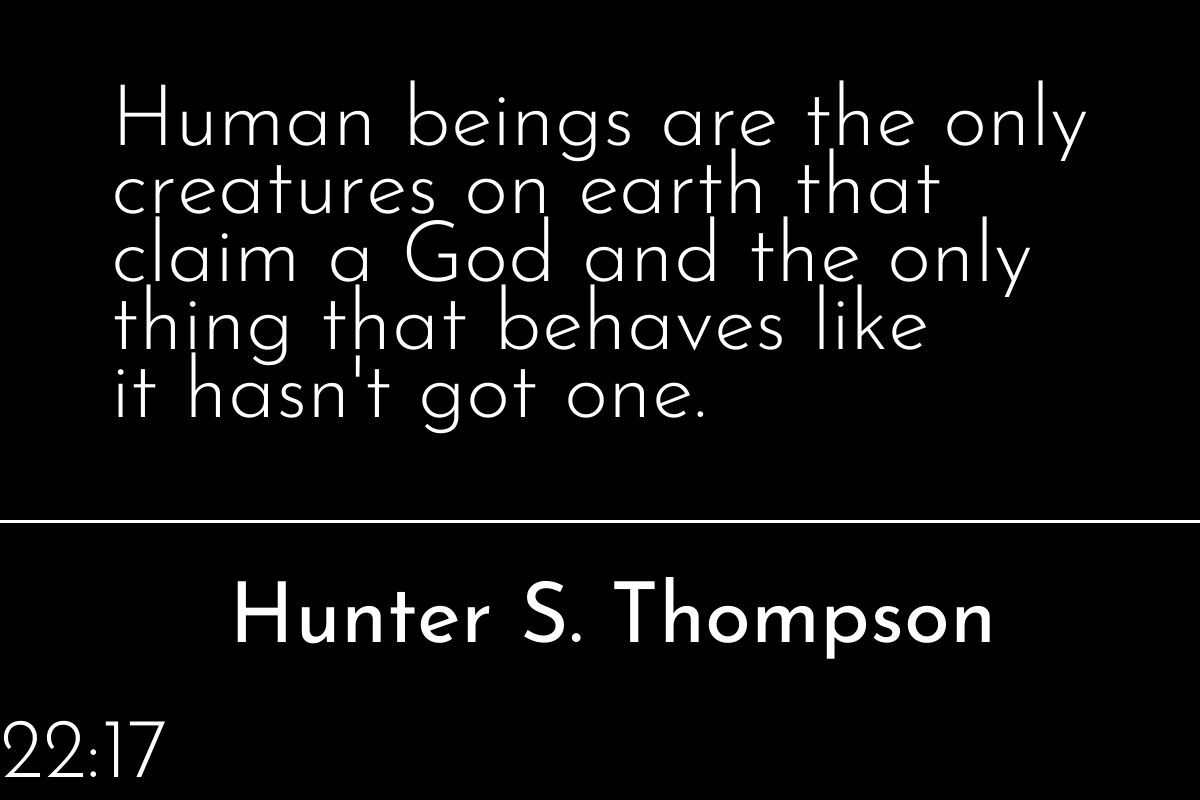

In [43]:
# # this simulates calling the plugin from PaperPi
# d = my_plugin()